# Experiments with real data (German Credit)

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

## Requirements

In [98]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', '..', 'data')
data_filename = 'uci_german_credit_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_german_credit import get_config as get_config_exp_1_german_credit
from config_experiment_3_german_credit import get_config as get_config_exp_3_german_credit
from config_experiment_4_german_credit import get_config as get_config_exp_4_german_credit

## Data exploration


### Conceptual description

| Variable              | Descripción                                    | Tipo                  | Valores                                                                 |
| --------------------- | ---------------------------------------------- | --------------------- | ----------------------------------------------------------------------- |
| credit-risk           | Etiqueta binaria del comportamiento crediticio | Binaria               | `good (1)`, `bad (0)`                                                   |
| checking_status       | Estado de la cuenta corriente del solicitante  | Categórica ordinal    | `no checking (0)`, `<0 (1)`, `0<=X<200 (2)`, `>=200 (3)`                |
| duration              | Duración del crédito en meses                  | Numérica (discreta)   | 6, 12, 24, 48, 60, ...                                                  |
| credit_history        | Historial crediticio previo del solicitante    | Categórica nominal    | `all paid (0)`, `critical/other existing credit (1)`, `delayed previously (2)`, `existing paid (3)`, `no credits/all paid (4)` |
| purpose               | Finalidad declarada del crédito                | Categórica nominal    | `business (0)`, `domestic appliance (1)`, `education (2)`, `furniture/equipment (3)`, `new car (4)`, `other (5)`, `radio/tv (6)`, `repairs (7)`, `retraining (8)`, `used car (9)` |
| credit_amount         | Monto del crédito solicitado                   | Numérica (continua)   | 250 – 18424 (ej.: 1169, 5951, 9055, ...)                                |
| savings_status        | Nivel de ahorro declarado                      | Categórica ordinal    | `no known savings (0)`, `<100 (1)`, `100<=X<500 (2)`, `500<=X<1000 (3)`, `>=1000 (4)` |
| employment            | Tiempo en el empleo actual                     | Categórica ordinal    | `unemployed (0)`, `<1 (1)`, `1<=X<4 (2)`, `4<=X<7 (3)`, `>=7 (4)`       |
| installment_commitment| Porcentaje del ingreso asignado a la cuota mensual | Categórica ordinal | 1, 2, 3, 4                                                              |
| other_parties         | Existencia de co-solicitante o avalista        | Categórica nominal    | `co applicant (0)`, `guarantor (1)`, `none (2)`                         |
| residence_since       | Años de residencia en el domicilio actual      | Numérica (discreta)   | 1, 2, 3, 4                                                              |
| property_magnitude    | Tipo de propiedad o garantía declarada         | Categórica nominal    | `car (0)`, `life insurance (1)`, `no known property (2)`, `real estate (3)` |
| age                   | Edad del solicitante                           | Numérica (continua)   | 19 – 75 (ej.: 22, 45, 53, ...)                                          |
| other_payment_plans   | Otros planes de pago disponibles               | Categórica nominal    | `bank (0)`, `none (1)`, `stores (2)`                                    |
| housing               | Régimen de vivienda                            | Categórica nominal    | `for free (0)`, `own (1)`, `rent (2)`                                   |
| existing_credits      | Número de créditos vigentes                    | Numérica (discreta)   | 1, 2, 3, 4                                                              |
| job                   | Tipo de ocupación                              | Categórica nominal    | `high qualif/self emp/mgmt (0)`, `skilled (1)`, `unemp/unskilled non res (2)`, `unskilled resident (3)` |
| num_dependents        | Número de personas dependientes                | Numérica (discreta)   | 1, 2                                                                    |
| own_telephone         | Si el solicitante tiene teléfono               | Binaria               | `none (0)`, `yes (1)`                                                   |
| foreign_worker        | Si el solicitante es trabajador extranjero     | Binaria               | `no (0)`, `yes (1)`                                                     |
| sex                   | Género del solicitante                         | Categórica nominal    | `female (0)`, `male (1)`                                                |
| marital_status        | Estado civil del solicitante                   | Categórica nominal    | `div/dep/mar (0)`, `div/sep (1)`, `mar/wid (2)`, `single (3)`           |


### Data reading

In [2]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

df, X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [3]:
df.head()

duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,credit-risk,own_telephone,foreign_worker,sex,checking_status,credit_history,purpose,savings_status,employment,other_parties,property_magnitude,other_payment_plans,housing,job,marital_status
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
6,1169,4,4,67,2,1,1,1,1,1,1,1,6,0,4,2,3,1,1,1,3
48,5951,2,2,22,1,1,0,0,1,0,2,3,6,1,2,2,3,1,1,1,0
12,2096,2,3,49,1,2,1,0,1,1,0,1,2,1,3,2,3,1,1,3,3
42,7882,2,4,45,1,2,1,0,1,1,1,3,3,1,3,1,1,1,0,1,3
24,4870,3,4,53,2,2,0,0,1,1,1,2,4,1,2,2,2,1,0,1,3


In [4]:
X.head()

duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,own_telephone,foreign_worker,sex,checking_status,credit_history,purpose,savings_status,employment,other_parties,property_magnitude,other_payment_plans,housing,job,marital_status
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
6,1169,4,4,67,2,1,1,1,1,1,1,6,0,4,2,3,1,1,1,3
48,5951,2,2,22,1,1,0,1,0,2,3,6,1,2,2,3,1,1,1,0
12,2096,2,3,49,1,2,0,1,1,0,1,2,1,3,2,3,1,1,3,3
42,7882,2,4,45,1,2,0,1,1,1,3,3,1,3,1,1,1,0,1,3
24,4870,3,4,53,2,2,0,1,1,1,2,4,1,2,2,2,1,0,1,3


In [5]:
y.head(5)

credit-risk
i64
1
0
1
1
0


In [6]:
config_exp_1 = get_config_exp_1_german_credit()

In [7]:
config_exp_1

{'frac_sample_sizes': array([0.01, 0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 ]),
 'n_clusters': None,
 'method': 'pam',
 'init': 'heuristic',
 'max_iter': 100,
 'p1': None,
 'p2': None,
 'p3': None,
 'd1': 'robust_mahalanobis',
 'd2': 'jaccard',
 'd3': 'hamming',
 'robust_method': 'trimmed',
 'alpha': 0.05,
 'epsilon': 0.05,
 'n_iters': 20,
 'VG_sample_size': 1000,
 'VG_n_samples': 5}

In [8]:
n_clusters

2

In [9]:
print(p1, p2, p3)

7 3 11


In [10]:
encoding

{'credit-risk': {'bad': 0, 'good': 1},
 'own_telephone': {'none': 0, 'yes': 1},
 'foreign_worker': {'no': 0, 'yes': 1},
 'sex': {'female': 0, 'male': 1},
 'credit_history': {'all paid': 0,
  'critical/other existing credit': 1,
  'delayed previously': 2,
  'existing paid': 3,
  'no credits/all paid': 4},
 'purpose': {'business': 0,
  'domestic appliance': 1,
  'education': 2,
  'furniture/equipment': 3,
  'new car': 4,
  'other': 5,
  'radio/tv': 6,
  'repairs': 7,
  'retraining': 8,
  'used car': 9},
 'other_parties': {'co applicant': 0, 'guarantor': 1, 'none': 2},
 'property_magnitude': {'car': 0,
  'life insurance': 1,
  'no known property': 2,
  'real estate': 3},
 'other_payment_plans': {'bank': 0, 'none': 1, 'stores': 2},
 'housing': {'for free': 0, 'own': 1, 'rent': 2},
 'job': {'high qualif/self emp/mgmt': 0,
  'skilled': 1,
  'unemp/unskilled non res': 2,
  'unskilled resident': 3},
 'marital_status': {'div/dep/mar': 0, 'div/sep': 1, 'mar/wid': 2, 'single': 3},
 'checking_stat

In [11]:
quant_predictors

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [12]:
binary_predictors

['own_telephone', 'foreign_worker', 'sex']

In [13]:
multiclass_predictors

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'marital_status']

### Data description

In [14]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [15]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
duration,33,0.0,20.903,12.058814,4,9.0,12.0,18.0,24.0,36.0,72,3.909195,1.092542,0.07
credit_amount,921,0.0,3271.258,2822.736876,250,932.0,1366.0,2319.5,3972.0,7174.0,18424,7.265163,1.946702,0.073
installment_commitment,4,0.0,2.973,1.118715,1,1.0,2.0,3.0,4.0,4.0,4,1.789577,-0.530551,0.0
residence_since,4,0.0,2.845,1.103718,1,1.0,2.0,3.0,4.0,4.0,4,1.619455,-0.272161,0.0
age,53,0.0,35.546,11.375469,19,23.0,27.0,33.0,42.0,52.0,75,3.586811,1.019208,0.023
existing_credits,4,0.0,1.407,0.577654,1,1.0,1.0,1.0,2.0,2.0,4,4.590434,1.270666,0.006
num_dependents,2,0.0,1.155,0.362086,1,1.0,1.0,1.0,1.0,2.0,2,4.635045,1.906579,0.155


In [16]:
cat_summary

,n_unique,perc_nan,mode
own_telephone,2,0.0,0
foreign_worker,2,0.0,1
sex,2,0.0,1
checking_status,4,0.0,0
credit_history,5,0.0,3
purpose,10,0.0,6
savings_status,5,0.0,1
employment,5,0.0,2
other_parties,3,0.0,2
property_magnitude,4,0.0,0


In [17]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.3, 1: 0.7}


In [18]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""duration""",-6.0,42.0,70,930,0.07,0.93
"""credit_amount""",-2543.0,7881.0,73,927,0.073,0.927
"""installment_commitment""",-1.0,7.0,0,1000,0.0,1.0
"""residence_since""",-1.0,7.0,0,1000,0.0,1.0
"""age""",4.5,64.5,23,977,0.023,0.977
"""existing_credits""",-0.5,3.5,6,994,0.006,0.994
"""num_dependents""",1.0,1.0,155,845,0.155,0.845


In [19]:
outliers_df['prop_outliers'].mean()

0.046714285714285715

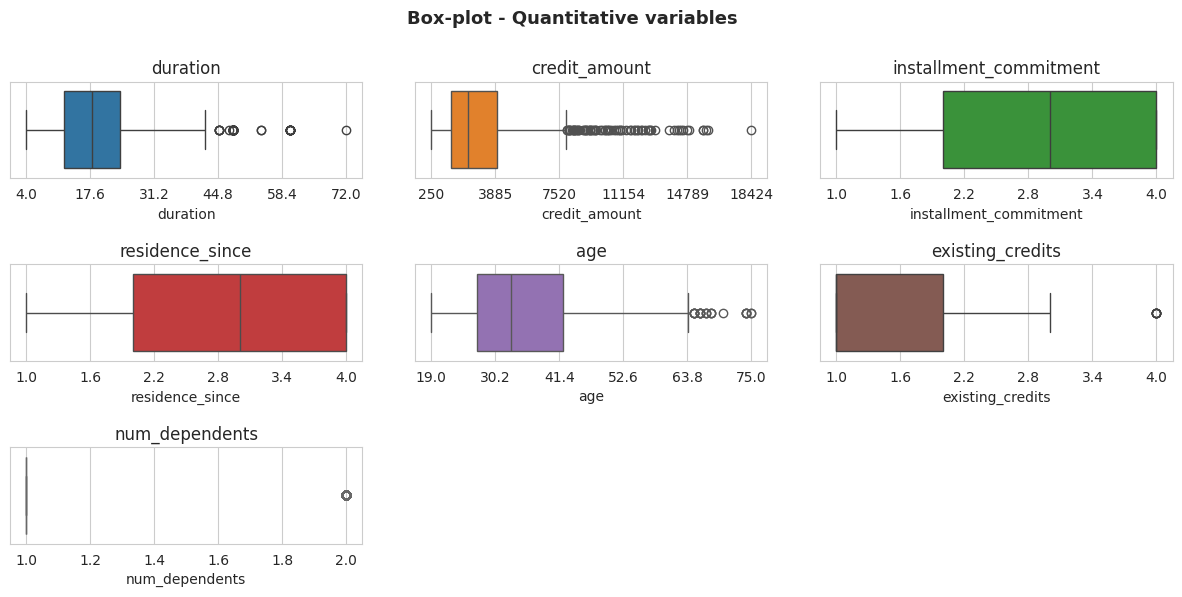

In [20]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,6), 
               quant_col_names = quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=1,
               style='whitegrid', 
               hspace=0.9, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

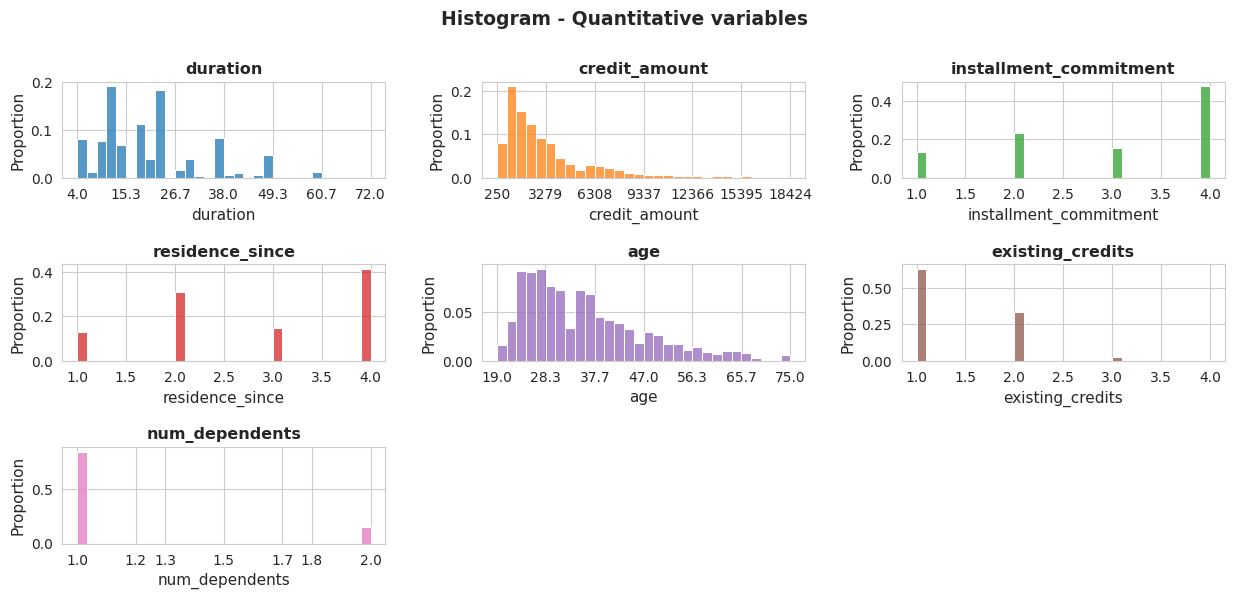

In [21]:
# Histogram
histogram_matrix(df=X, 
                 bins=30, 
                 n_cols=3, 
                 title='Histogram - Quantitative variables', 
                 figsize=(15,6), 
                 quant_col_names = quant_predictors, 
                 n_xticks=7, 
                 title_fontsize=13.5, 
                 subtitles_fontsize=11.5, 
                 save=False, 
                 file_name='', 
                 x_rotation=0, 
                 title_height=1,
                 style='whitegrid', 
                 hspace=0.9, 
                 wspace=0.3, 
                 n_round_xticks=1)

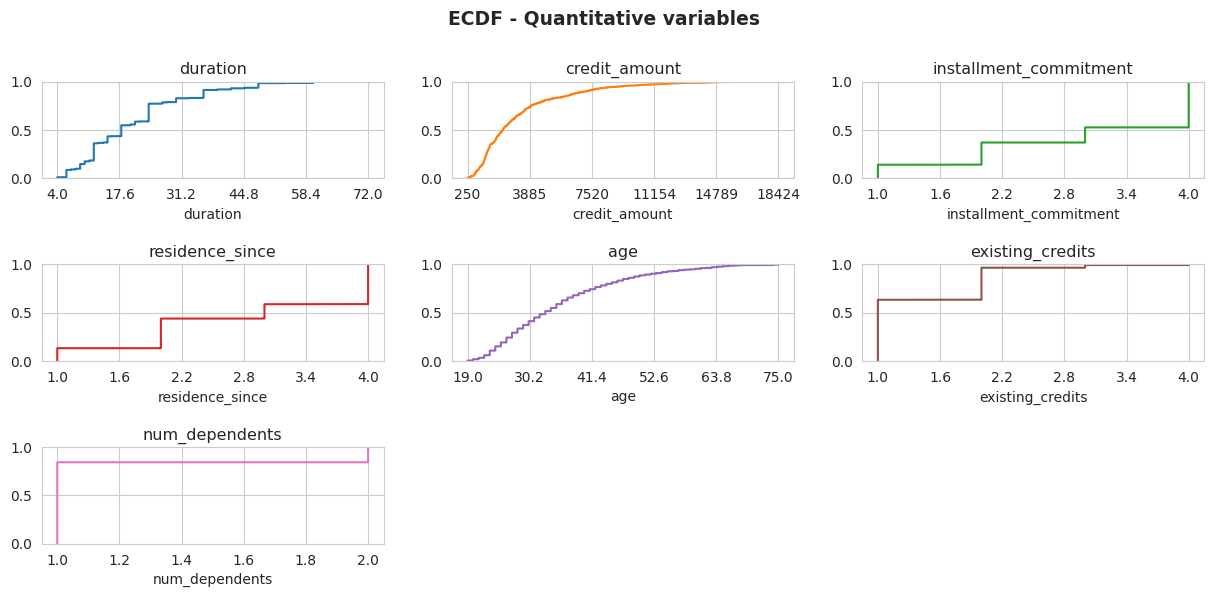

In [22]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='ECDF - Quantitative variables', 
                complementary=False, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

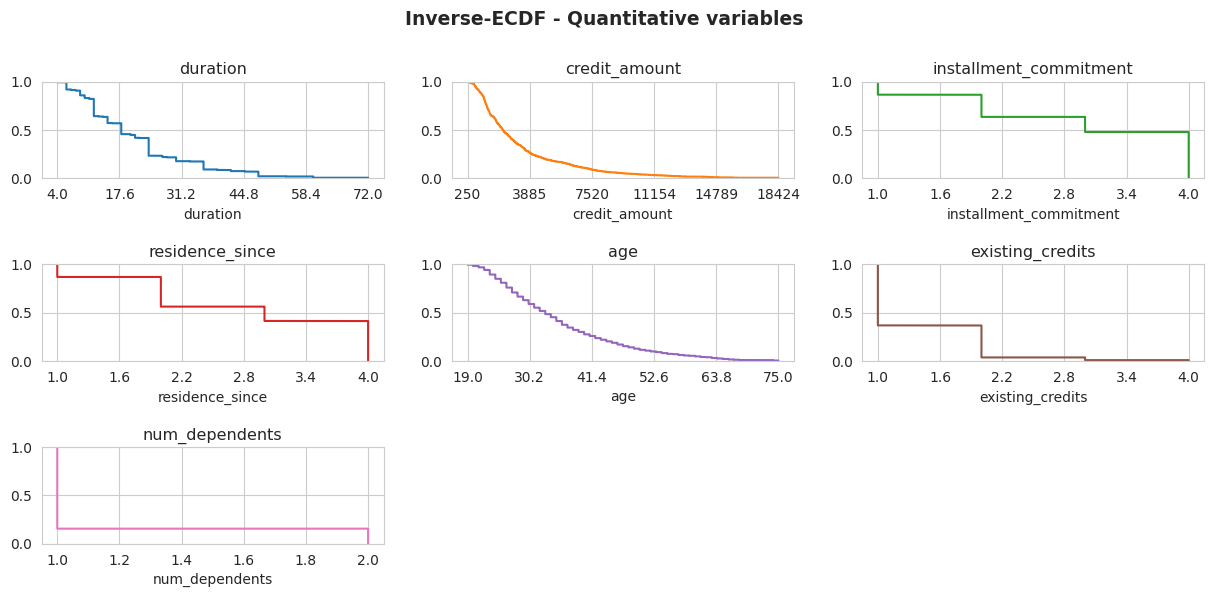

In [23]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

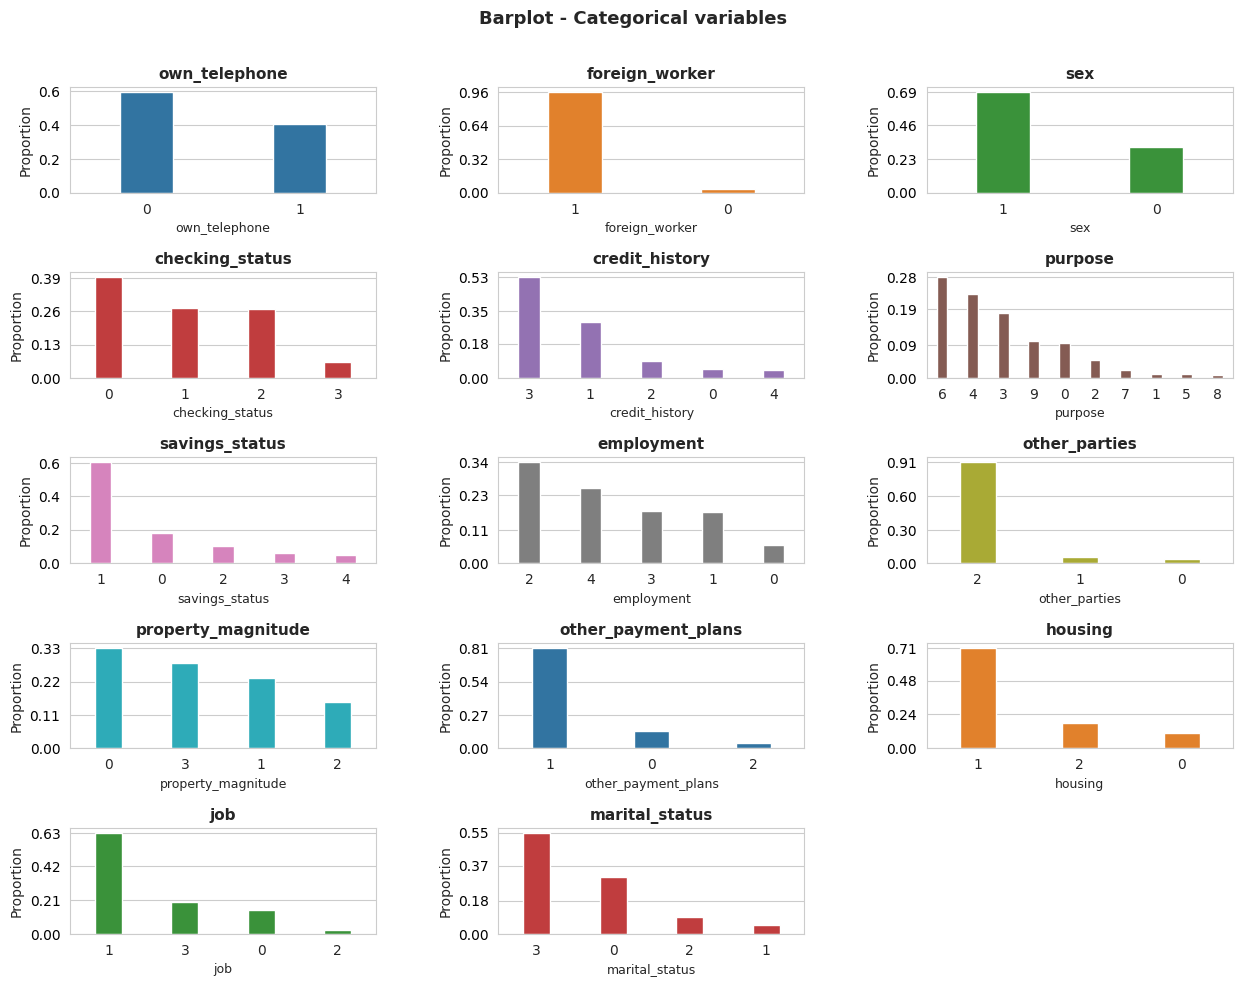

In [24]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,11), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [25]:
# Correlation Matrix
X[quant_predictors].corr()

duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
f64,f64,f64,f64,f64,f64,f64
1.0,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834
0.624984,1.0,-0.271316,0.028926,0.032716,0.020795,0.017142
0.074749,-0.271316,1.0,0.049302,0.058266,0.021669,-0.071207
0.034067,0.028926,0.049302,1.0,0.266419,0.089625,0.042643
-0.036136,0.032716,0.058266,0.266419,1.0,0.149254,0.118201
-0.011284,0.020795,0.021669,0.089625,0.149254,1.0,0.109667
-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.0


In [26]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.05
Proportion of pair-wise correlations in [0.30, 0.60]:  0.0
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.95



## Experiment 1


In [36]:
run_experiment_1 = True

In [ ]:
if run_experiment_1: 
        
    n_realizations = 250
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_1', 'german_credit')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    config_exp_1 = get_config_exp_1_german_credit()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy() # needed by adjusted_accuracy, which is used by make_experiment_1

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score
                                                    #metric=balanced_accuracy_score # y is unbalanced, so balance acc should be used, but for keeping coherence with the simulated experiments, we will keep acc.
                                                )
            
        # Save results
        results_filename = f'results_exp_1_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 41 mins

chunks:   0%|          | 0/50 [00:00<?, ?chunks/s]

random_state_chunk: [13726, 70169, 22855, 201577, 106755]
random_state: 13726
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 70169
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 22855
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 201577
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks:   2%|▏         | 1/50 [00:50<41:18, 50.57s/chunks]

random_state_chunk: [69875, 28232, 219808, 236243, 229330]
random_state: 69875
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 28232
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 219808
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 236243
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:   4%|▍         | 2/50 [01:37<38:46, 48.46s/chunks]

random_state_chunk: [10001, 99385, 140562, 147408, 87083]
random_state: 10001
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 99385
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 140562
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 147408
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:   6%|▌         | 3/50 [02:28<38:55, 49.70s/chunks]

random_state_chunk: [89338, 223369, 13605, 41854, 35404]
random_state: 89338
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 223369
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 13605
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 41854
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 

chunks:   8%|▊         | 4/50 [03:18<38:11, 49.82s/chunks]

random_state_chunk: [88399, 147052, 87502, 183943, 64268]
random_state: 88399
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 147052
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 87502
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 183943
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  10%|█         | 5/50 [04:13<38:34, 51.44s/chunks]

random_state_chunk: [42933, 437, 237477, 114367, 202791]
random_state: 42933
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 437
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 237477
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 114367
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0

chunks:  12%|█▏        | 6/50 [05:03<37:32, 51.20s/chunks]

random_state_chunk: [22967, 230327, 156657, 98984, 18317]
random_state: 22967
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 230327
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 156657
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 98984
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  14%|█▍        | 7/50 [05:52<36:03, 50.31s/chunks]

random_state_chunk: [1728, 82695, 191899, 117524, 26748]
random_state: 1728
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 82695
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 191899
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 117524
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 

chunks:  16%|█▌        | 8/50 [06:42<35:17, 50.41s/chunks]

random_state_chunk: [237344, 11504, 24317, 174886, 37270]
random_state: 237344
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 11504
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 24317
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 174886
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  18%|█▊        | 9/50 [07:34<34:36, 50.64s/chunks]

random_state_chunk: [33095, 207112, 237661, 5566, 76494]
random_state: 33095
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 207112
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 237661
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 5566
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 

chunks:  20%|██        | 10/50 [08:22<33:16, 49.92s/chunks]

random_state_chunk: [238852, 112889, 150315, 125022, 69552]
random_state: 238852
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 112889
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 150315
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 125022
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_

chunks:  22%|██▏       | 11/50 [09:09<31:52, 49.04s/chunks]

random_state_chunk: [123022, 219634, 9632, 201534, 79979]
random_state: 123022
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 219634
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 9632
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 201534
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  24%|██▍       | 12/50 [09:57<30:55, 48.82s/chunks]

random_state_chunk: [90036, 136752, 210107, 126605, 54227]
random_state: 90036
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 136752
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 210107
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 126605
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_si

chunks:  26%|██▌       | 13/50 [10:49<30:41, 49.77s/chunks]

random_state_chunk: [215291, 159620, 167446, 138169, 148062]
random_state: 215291
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 159620
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 167446
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 138169
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample

chunks:  28%|██▊       | 14/50 [11:38<29:44, 49.57s/chunks]

random_state_chunk: [212163, 82644, 3289, 104395, 234079]
random_state: 212163
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 82644
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 3289
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 104395
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks:  30%|███       | 15/50 [12:28<28:53, 49.52s/chunks]

random_state_chunk: [201661, 169385, 134414, 113871, 179525]
random_state: 201661
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 169385
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 134414
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 113871
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample

chunks:  32%|███▏      | 16/50 [13:16<27:49, 49.10s/chunks]

random_state_chunk: [141169, 167340, 208789, 174760, 156370]
random_state: 141169
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 167340
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 208789
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 174760
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample

chunks:  34%|███▍      | 17/50 [14:04<26:54, 48.92s/chunks]

random_state_chunk: [233333, 218499, 127437, 136474, 175235]
random_state: 233333
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 218499
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 127437
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 136474
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample

chunks:  36%|███▌      | 18/50 [14:53<26:04, 48.90s/chunks]

random_state_chunk: [109968, 98178, 133710, 8347, 222125]
random_state: 109968
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 98178
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 133710
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 8347
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks:  38%|███▊      | 19/50 [15:43<25:21, 49.07s/chunks]

random_state_chunk: [197701, 169201, 47569, 190271, 215007]
random_state: 197701
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 169201
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 47569
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 190271
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  40%|████      | 20/50 [16:31<24:28, 48.94s/chunks]

random_state_chunk: [21655, 239506, 127639, 172510, 68652]
random_state: 21655
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 239506
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 127639
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 172510
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_si

chunks:  42%|████▏     | 21/50 [17:22<23:59, 49.63s/chunks]

random_state_chunk: [44597, 87792, 88320, 145281, 102548]
random_state: 44597
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 87792
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 88320
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 145281
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks:  44%|████▍     | 22/50 [18:12<23:11, 49.71s/chunks]

random_state_chunk: [231713, 19212, 189559, 119738, 101621]
random_state: 231713
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 19212
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 189559
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 119738
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  46%|████▌     | 23/50 [19:03<22:26, 49.85s/chunks]

random_state_chunk: [150252, 204141, 88108, 4275, 49561]
random_state: 150252
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 204141
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 88108
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 4275
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 

chunks:  48%|████▊     | 24/50 [19:52<21:32, 49.72s/chunks]

random_state_chunk: [153669, 23109, 217999, 164709, 95293]
random_state: 153669
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 23109
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 217999
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 164709
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_si

chunks:  50%|█████     | 25/50 [20:44<20:56, 50.27s/chunks]

random_state_chunk: [3363, 234920, 92252, 60064, 106356]
random_state: 3363
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 234920
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 92252
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 60064
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0

chunks:  52%|█████▏    | 26/50 [21:32<19:52, 49.67s/chunks]

random_state_chunk: [139459, 131336, 189704, 216030, 238329]
random_state: 139459
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 131336
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 189704
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 216030
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample

chunks:  54%|█████▍    | 27/50 [22:22<19:03, 49.74s/chunks]

random_state_chunk: [15656, 167457, 75419, 129703, 200327]
random_state: 15656
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 167457
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 75419
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 129703
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:  56%|█████▌    | 28/50 [23:11<18:13, 49.70s/chunks]

random_state_chunk: [165148, 188821, 61177, 142650, 126828]
random_state: 165148
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 188821
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 61177
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 142650
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  58%|█████▊    | 29/50 [24:01<17:22, 49.62s/chunks]

random_state_chunk: [46554, 40307, 140608, 116522, 99245]
random_state: 46554
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 40307
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 140608
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 116522
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  60%|██████    | 30/50 [24:52<16:41, 50.05s/chunks]

random_state_chunk: [197040, 120925, 11568, 2661, 35318]
random_state: 197040
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 120925
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 11568
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 2661
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 

chunks:  62%|██████▏   | 31/50 [25:40<15:40, 49.50s/chunks]

random_state_chunk: [119626, 50640, 5507, 67203, 209423]
random_state: 119626
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 50640
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 5507
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 67203
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0

chunks:  64%|██████▍   | 32/50 [26:30<14:53, 49.65s/chunks]

random_state_chunk: [92287, 179559, 71284, 113840, 166269]
random_state: 92287
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 179559
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 71284
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 113840
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:  66%|██████▌   | 33/50 [27:22<14:14, 50.26s/chunks]

random_state_chunk: [110194, 93, 28474, 161896, 16412]
random_state: 110194
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 93
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 28474
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 161896
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4


chunks:  68%|██████▊   | 34/50 [28:15<13:40, 51.28s/chunks]

random_state_chunk: [133777, 93077, 185349, 23275, 21733]
random_state: 133777
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 93077
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 185349
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 23275
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  70%|███████   | 35/50 [29:06<12:46, 51.11s/chunks]

random_state_chunk: [113560, 235268, 2244, 208597, 140457]
random_state: 113560
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 235268
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 2244
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 208597
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:  72%|███████▏  | 36/50 [29:57<11:54, 51.02s/chunks]

random_state_chunk: [98948, 19263, 143283, 181981, 166485]
random_state: 98948
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 19263
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 143283
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 181981
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:  74%|███████▍  | 37/50 [30:48<11:03, 51.05s/chunks]

random_state_chunk: [105960, 7638, 84530, 68823, 123865]
random_state: 105960
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 7638
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 84530
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 68823
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0

chunks:  76%|███████▌  | 38/50 [31:38<10:07, 50.67s/chunks]

random_state_chunk: [8658, 196821, 147216, 87773, 108546]
random_state: 8658
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 196821
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 147216
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 87773
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks:  78%|███████▊  | 39/50 [32:27<09:13, 50.35s/chunks]

random_state_chunk: [91322, 6236, 167543, 166745, 42954]
random_state: 91322
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 6236
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 167543
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 166745
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 

chunks:  80%|████████  | 40/50 [33:16<08:19, 49.94s/chunks]

random_state_chunk: [231703, 109848, 16841, 188145, 227992]
random_state: 231703
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 109848
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 16841
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 188145
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  82%|████████▏ | 41/50 [34:07<07:30, 50.02s/chunks]

random_state_chunk: [178009, 37744, 97546, 175311, 61594]
random_state: 178009
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 37744
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 97546
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 175311
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size

chunks:  84%|████████▍ | 42/50 [34:54<06:34, 49.37s/chunks]

random_state_chunk: [195065, 20545, 216205, 230400, 164501]
random_state: 195065
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 20545
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 216205
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 230400
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  86%|████████▌ | 43/50 [35:44<05:45, 49.34s/chunks]

random_state_chunk: [14983, 198721, 135973, 101504, 140911]
random_state: 14983
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 198721
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 135973
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 101504
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  88%|████████▊ | 44/50 [36:33<04:56, 49.36s/chunks]

random_state_chunk: [80258, 38309, 239526, 171948, 202493]
random_state: 80258
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 38309
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 239526
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 171948
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:  90%|█████████ | 45/50 [37:25<04:11, 50.27s/chunks]

random_state_chunk: [240077, 76334, 203458, 219067, 102041]
random_state: 240077
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 76334
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 203458
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 219067
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_s

chunks:  92%|█████████▏| 46/50 [38:13<03:17, 49.37s/chunks]

random_state_chunk: [96596, 33153, 140226, 88532, 135555]
random_state: 96596
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 33153
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 140226
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 88532
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks:  94%|█████████▍| 47/50 [39:03<02:29, 49.67s/chunks]

random_state_chunk: [31343, 165050, 43726, 210312, 154480]
random_state: 31343
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 165050
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 43726
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 210312
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_siz

chunks:  96%|█████████▌| 48/50 [39:55<01:40, 50.39s/chunks]

random_state_chunk: [101252, 113293, 16267, 194343, 35655]
random_state: 101252
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 113293
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 16267
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 194343
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_si

chunks:  98%|█████████▊| 49/50 [40:45<00:50, 50.12s/chunks]

random_state_chunk: [119207, 175229, 5403, 91629, 117892]
random_state: 119207
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 175229
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 5403
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size: 0.4
frac_sample_size: 0.5
frac_sample_size: 0.6
frac_sample_size: 0.7
frac_sample_size: 0.8
frac_sample_size: 0.9
random_state: 91629
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
frac_sample_size: 0.3
frac_sample_size:

chunks: 100%|██████████| 50/50 [41:33<00:00, 49.86s/chunks]


In [39]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_german_credit_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [28]:
# Open merged/joined results 

file_id = '20250922_163136'
results_filename = f'results_exp_1_german_credit_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_1', 'german_credit')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [29]:
experiment_1_config = get_config_exp_1_german_credit()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [30]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

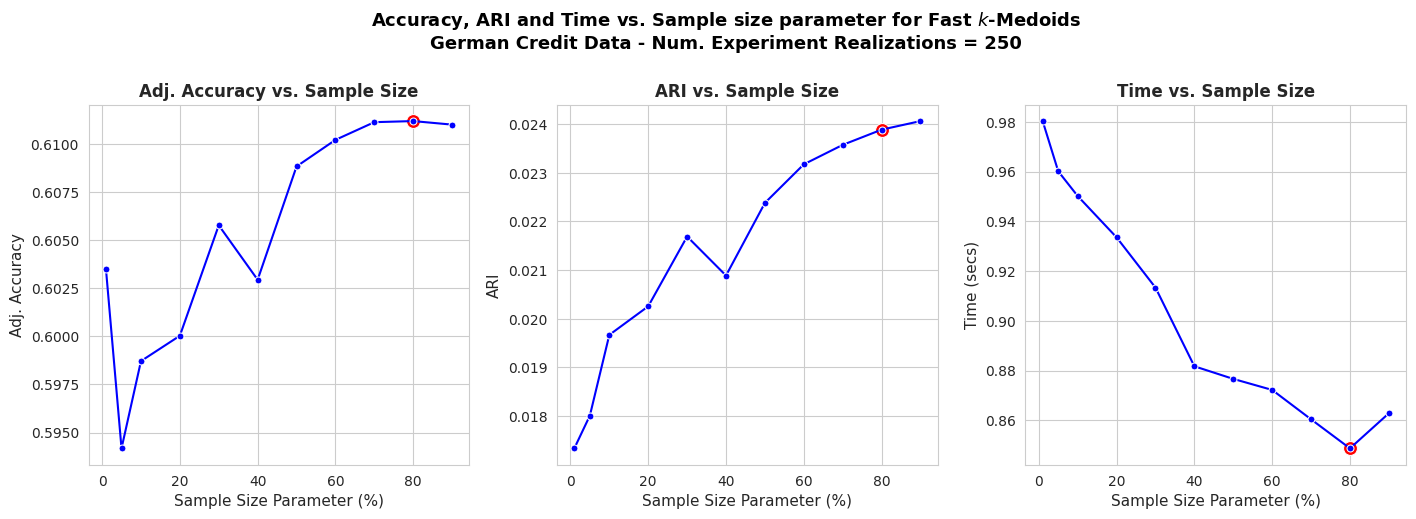

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nGerman Credit Data - Num. Experiment Realizations = 250', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_german_credit_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


## Experiment 3


In [3]:
run_experiment_3 = True

In [5]:
if run_experiment_3: 

    n_realizations = 250
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_3', 'german_credit')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    config_exp_3 = get_config_exp_3_german_credit()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks[76:], desc='chunks', unit='chunks', position=0), start=76):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 500 mins

chunks:   0%|          | 0/8 [00:00<?, ?chunks/s]

random_state_chunk: [219067, 102041, 96596]
random_state: 219067
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


random_state: 102041
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


random_state: 96596
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.8


chunks:  12%|█▎        | 1/8 [06:06<42:45, 366.51s/chunks]

random_state_chunk: [33153, 140226, 88532]
random_state: 33153
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


random_state: 140226
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


random_state: 88532
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


frac_sample_size: 0.8


chunks:  25%|██▌       | 2/8 [12:24<37:18, 373.07s/chunks]

random_state_chunk: [135555, 31343, 165050]
random_state: 135555
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


random_state: 31343
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


random_state: 165050
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


frac_sample_size: 0.8


chunks:  38%|███▊      | 3/8 [18:33<30:57, 371.53s/chunks]

random_state_chunk: [43726, 210312, 154480]
random_state: 43726
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


random_state: 210312
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


random_state: 154480
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.8


chunks:  50%|█████     | 4/8 [24:43<24:42, 370.68s/chunks]

random_state_chunk: [101252, 113293, 16267]
random_state: 101252
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


random_state: 113293
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


random_state: 16267
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


frac_sample_size: 0.8


chunks:  62%|██████▎   | 5/8 [30:51<18:29, 369.91s/chunks]

random_state_chunk: [194343, 35655, 119207]
random_state: 194343
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


random_state: 35655
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


random_state: 119207
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.8


chunks:  75%|███████▌  | 6/8 [37:04<12:21, 370.95s/chunks]

random_state_chunk: [175229, 5403, 91629]
random_state: 175229
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


random_state: 5403
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


random_state: 91629
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


frac_sample_size: 0.8


chunks:  88%|████████▊ | 7/8 [43:11<06:09, 369.42s/chunks]

random_state_chunk: [117892]
random_state: 117892
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.8


chunks: 100%|██████████| 8/8 [45:15<00:00, 339.47s/chunks]


In [ ]:
# Change results filenames replacing 'simu_1' by 'german_credit'
'''
filenames_to_change = [f for f in os.listdir(results_folder_path) if 'simu_1' in f]
for f in filenames_to_change:
    new_name = f.replace('simu_1', 'german_credit')
    old_path = os.path.join(results_folder_path, f)
    new_path = os.path.join(results_folder_path, new_name)
    os.rename(old_path, new_path)
'''

In [19]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250922_225848'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_german_credit_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [33]:
# Open merged/joined results 

file_id = '20250922_225848'
results_filename = f'results_exp_3_german_credit_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_3', 'german_credit')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [34]:
config_exp_3 = get_config_exp_3_german_credit()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

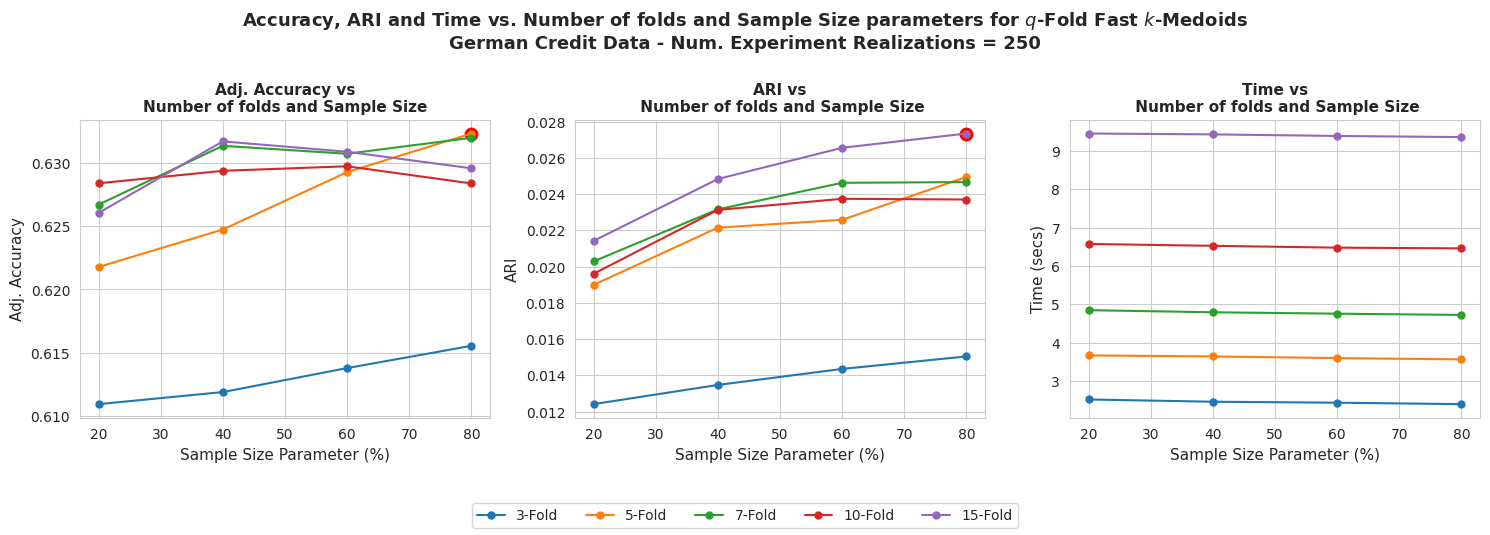

In [23]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nGerman Credit Data - Num. Experiment Realizations = 250", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_german_credit_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [24]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,3,0.2,0.610916,0.012407,2.525338
1,3,0.4,0.611872,0.013466,2.466258
2,3,0.6,0.613772,0.014350,2.441138
3,3,0.8,0.615536,0.015039,2.403588
4,5,0.2,0.621784,0.018986,3.672651
5,5,0.4,0.624752,0.022145,3.645124
6,5,0.6,0.629296,0.022580,3.602768
7,5,0.8,0.632360,0.024942,3.567890
8,7,0.2,0.626724,0.020283,4.849895
9,7,0.4,0.631384,0.023155,4.795408


In [25]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.5 
 best_n_splits 5.0 
 best_frac_sample_size 0.8



## Experiment 4

In [135]:
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana

config_exp_4 = get_config_exp_4_german_credit()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 150
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            
        models[random_state][f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [136]:
run_experiment_4 = True

In [ ]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_4', 'german_credit')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas
   
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state])

        # Save results
        results_filename = f'results_exp_4_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

chunks:   0%|          | 0/50 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [13726, 70169, 22855]
random_state: 13726
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


random_state: 70169
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


random_state: 22855
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   2%|▏         | 1/50 [01:34<1:17:29, 94.88s/chunks]

chunk_id 1
random_state_chunk: [106755, 69875, 28232]
random_state: 106755
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


random_state: 69875
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


random_state: 28232
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   4%|▍         | 2/50 [03:08<1:15:23, 94.24s/chunks]

chunk_id 2
random_state_chunk: [10001, 99385, 140562]
random_state: 10001
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


random_state: 99385
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


random_state: 140562
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   6%|▌         | 3/50 [04:42<1:13:46, 94.17s/chunks]

chunk_id 3
random_state_chunk: [147408, 87083, 89338]
random_state: 147408
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


random_state: 87083
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


random_state: 89338
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   8%|▊         | 4/50 [06:16<1:12:00, 93.93s/chunks]

chunk_id 4
random_state_chunk: [13605, 41854, 35404]
random_state: 13605
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


random_state: 41854
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


random_state: 35404
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  10%|█         | 5/50 [07:51<1:10:40, 94.23s/chunks]

chunk_id 5
random_state_chunk: [88399, 147052, 87502]
random_state: 88399
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


random_state: 147052
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


random_state: 87502
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  12%|█▏        | 6/50 [09:26<1:09:24, 94.65s/chunks]

chunk_id 6
random_state_chunk: [64268, 42933, 437]
random_state: 64268
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


random_state: 42933
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 437
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  14%|█▍        | 7/50 [11:08<1:09:39, 97.19s/chunks]

chunk_id 7
random_state_chunk: [114367, 22967, 98984]
random_state: 114367
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 22967
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


random_state: 98984
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  16%|█▌        | 8/50 [12:52<1:09:21, 99.09s/chunks]

chunk_id 8
random_state_chunk: [18317, 1728, 82695]
random_state: 18317
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 1728
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 82695
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  18%|█▊        | 9/50 [14:35<1:08:43, 100.58s/chunks]

chunk_id 9
random_state_chunk: [117524, 26748, 11504]
random_state: 117524
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


random_state: 26748
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


random_state: 11504
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  20%|██        | 10/50 [16:18<1:07:32, 101.32s/chunks]

chunk_id 10
random_state_chunk: [24317, 37270, 33095]
random_state: 24317
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 37270
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 33095
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  22%|██▏       | 11/50 [18:02<1:06:18, 102.01s/chunks]

chunk_id 11
random_state_chunk: [5566, 76494, 112889]
random_state: 5566
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 76494
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 112889
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  24%|██▍       | 12/50 [19:44<1:04:32, 101.92s/chunks]

chunk_id 12
random_state_chunk: [125022, 69552, 123022]
random_state: 125022
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


random_state: 69552
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


random_state: 123022
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  26%|██▌       | 13/50 [21:28<1:03:14, 102.56s/chunks]

chunk_id 13
random_state_chunk: [9632, 79979, 90036]
random_state: 9632
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


random_state: 79979
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 90036
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  28%|██▊       | 14/50 [23:10<1:01:28, 102.46s/chunks]

chunk_id 14
random_state_chunk: [136752, 126605, 54227]
random_state: 136752
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


random_state: 126605
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


In [112]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'german_credit')
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_german_credit_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_german_credit_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [113]:
# Open merged/joined results 

results_filename = f'results_exp_4_german_credit_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'german_credit')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [115]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [117]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

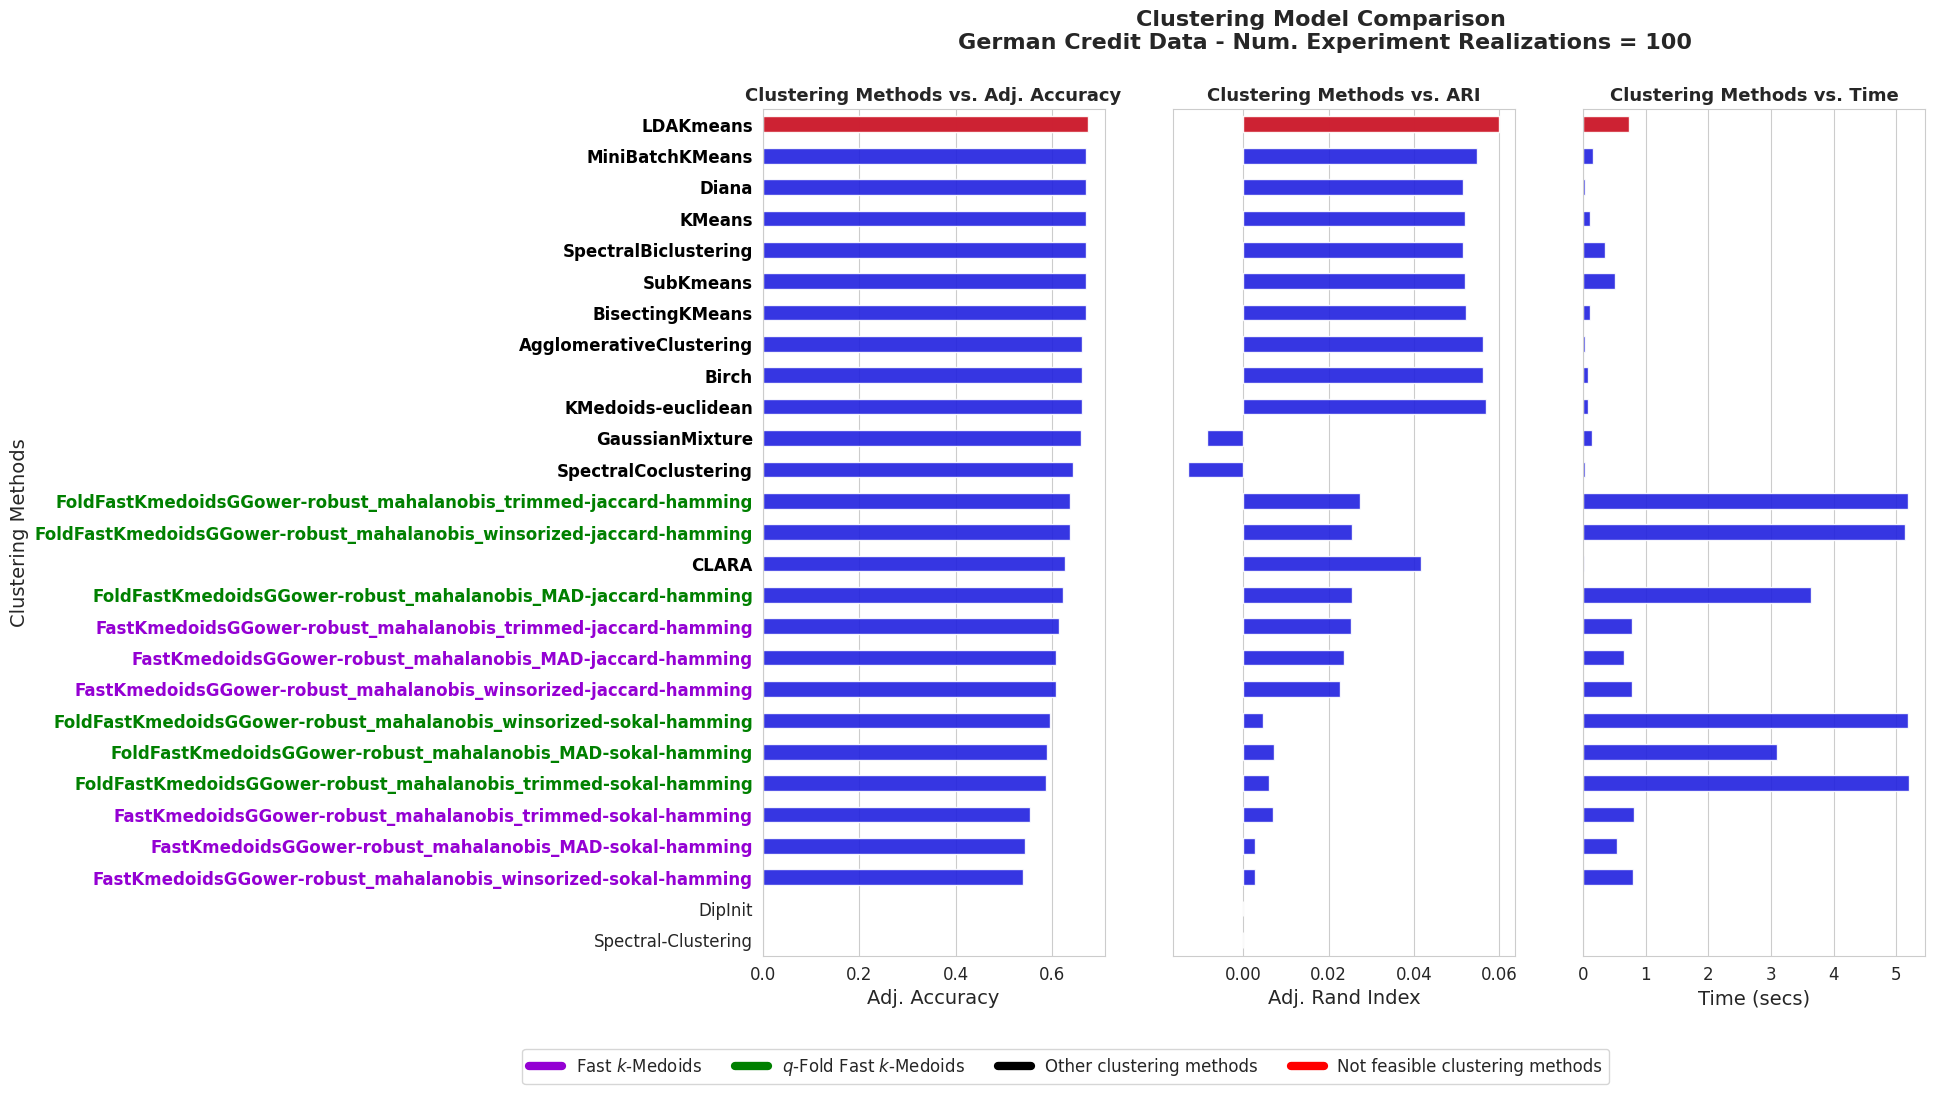

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    #elif label.get_text() in not_feasible_methods:
    #    label.set_weight('bold')
    #    label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - German Credit Data\nNum. Experiment Realizations = 150", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_german_credit_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [120]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [121]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
LDAKmeans,0.733246,0.675000,0.060049
MiniBatchKMeans,0.156801,0.671200,0.054717
Diana,0.020957,0.671000,0.051605
BisectingKMeans,0.101222,0.671000,0.052280
SubKmeans,0.513155,0.671000,0.051943
SpectralBiclustering,0.340182,0.671000,0.051605
KMeans,0.100828,0.671000,0.052112
AgglomerativeClustering,0.024469,0.661000,0.056115
Birch,0.073607,0.661000,0.056115


In [122]:
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods


In [ ]:
random_state_mds = 857

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.4, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

 

/home/fabio/fabio_scielzo_ortiz/tasks/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [126]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


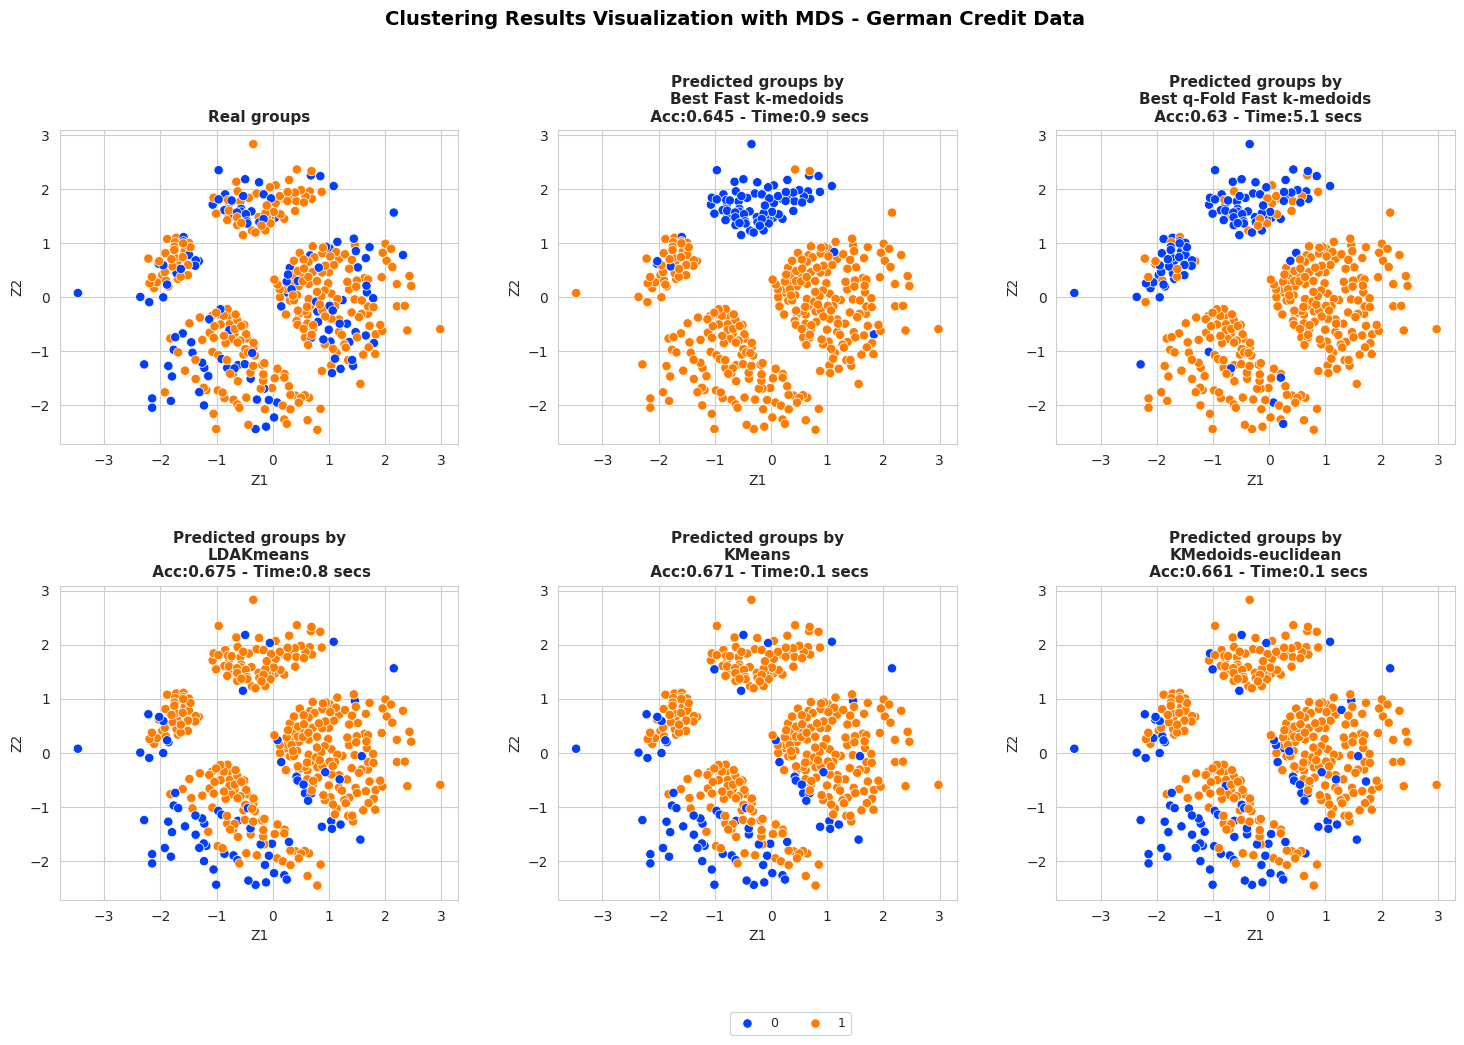

In [127]:
plot_filename = f'mds_plot_exp_4_german_credit_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'german_credit')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - German Credit Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)